<a href="https://colab.research.google.com/github/RamiroPadilla/Procesamiento-de-Imagenes-Sadosky2024/blob/main/Practica_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 1: Reconocimiento de dígitos manuscritos con extracción manual de características

El nuevo banco "First bank of Wiki" desea implementar un sistema de reconocimiento automático de cheques como el siguiente:

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/b/b9/CanadianChequeSample.png)


Actualmente, el banco cuenta con un sistema capaz de aislar los dígitos y convertirlos en imágenes de 8 x 8, pero no de reconocer de qué dígito se trata. Por esa razón, nos ha solicitado realizar un módulo capaz de reconocer dígitos manuscritos dada una imagen de 8 x 8 pixeles:


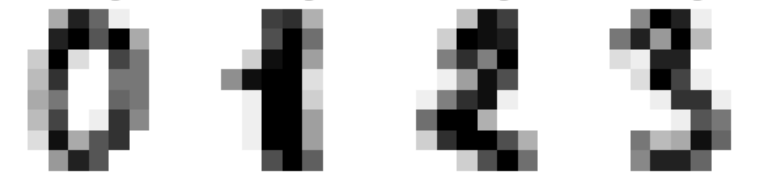



# Cargando los datos

Primero vamos a cargar el dataset y visualizar algunos dígitos.

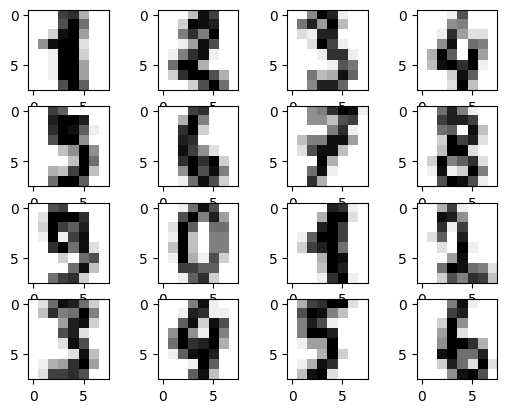

In [11]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(digits.images[i,:,:], cmap=plt.get_cmap('gray_r'))


# Binarizando el problema

Para comenzar con un problema más simple, sólo trabajaremos en el escenario de clasificación binaria para dígitos 0 y 1. Para eso, primero filtramos los datos y luego los particionamos en training y test folds.

In [12]:
# Cargo los dígitos
#X, y = load_digits(return_X_y=True)
X, y = digits.images, digits.target

# Filtro los que sean 0 o 1
indices = np.array(range(X.shape[0]))
bin_indices = indices[(y==0) | (y == 1)]

X_bin = X[bin_indices,:,:]
y_bin = y[bin_indices]

# Creo los splits para training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.33, random_state=42)

print("Total de datos para clasificación entre 10 dígitos: " + str(y.shape[0]))
print("Total de datos para clasificación binaria: " + str(y_bin.shape[0]))
print("Total de 1s para clasificación binaria: " + str(y_bin_test.sum()))
print("Total de 0s para clasificación binaria: " + str(y_bin_test.shape[0] - y_bin_test.sum()))


Total de datos para clasificación entre 10 dígitos: 1797
Total de datos para clasificación binaria: 360
Total de 1s para clasificación binaria: 60
Total de 0s para clasificación binaria: 59


Visualizamos ahora los dígitos del problema binario

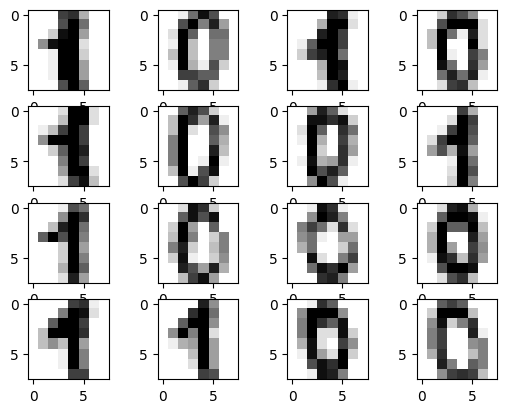

In [13]:
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(X_bin[i,:,:], cmap=plt.get_cmap('gray_r'))

# Entrenando un perceptrón simple con extracción manual de características para clasificación binaria

Ahora procederemos a entrenar un perceptrón usando la biblioteca Scikit Learn. Esta biblioteca de aprendizaje automático implementa muchísimos modelos listos para usar. En este caso, usaremos el perceptrón simple `sklearn.linear_model.Perceptron`

Pero antes de definir el perceptrón, vamos a definir el método de extracción de características que transformará una imagen (`np.array`) de 8 x 8 en un vector unidimensional de 2 componentes. Para ello, podemos probar con dos estrategias diferentes (si se les ocurre alguna otra, adelante!):

* **Estrategia 1:** vamos a considerar la feature 0 como la media de intensidades de la parte superior del dígito (filas 0 a 3) y y la feature 1 como la media de la parte inferior (filas 4 a 7) tal como indica la imagen:

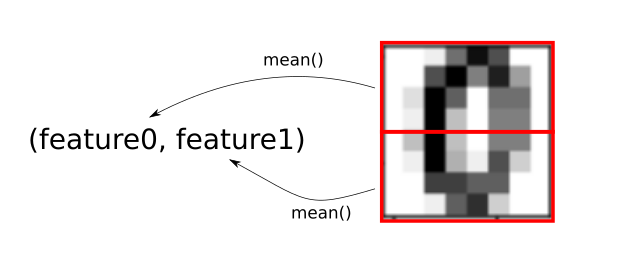

* **Estrategia 2:** Como alternativa, vamos a considerar la feature 0 como la media de toda la imagen, y la feature 1 como el desvío estandar:

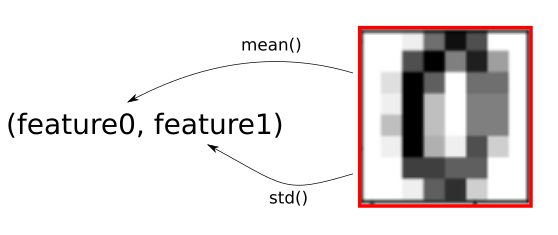


In [14]:
def extract_features_mean_std(x):
  x_out = np.zeros(shape=(1,2))
  x_out[0,0] = np.mean(x)
  x_out[0,1] = np.std(x)

  return x_out

def extract_features_mean_top_bottom(x):
  x_out = np.zeros(shape=(1,2))

  x_out[0,0] = np.mean(x[:4,:])
  x_out[0,1] = np.mean(x[4:,:])
  return x_out

def preprocess_features_mean_std(X):
  X_pp = np.zeros(shape=(X.shape[0], 2))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_std(X[i,:,:])

  return X_pp

def preprocess_features_mean_top_bottom(X):
  X_pp = np.zeros(shape=(X.shape[0], 2))

  for i in range(X.shape[0]):
    X_pp[i,:] = extract_features_mean_top_bottom(X[i,:,:])

  return X_pp

Ahora implementamos el perceptrón usando la clase `sklearn.linear_model.Perceptron` y lo entrenamos usando las features elegidas (probar con ambas features y ver cuál da mejor accuracy).

In [15]:
from sklearn.linear_model import Perceptron
# Definimos un pereceptrón
clasificador = Perceptron(max_iter=55, eta0=0.1, random_state=1)

# # Resultados para la estrategia 1 #
# Transformamos las features de los datos para el problema binario
X_bin_train_features = preprocess_features_mean_top_bottom(X_bin_train)
X_bin_test_features = preprocess_features_mean_top_bottom(X_bin_test)

# Entrenamos el clasificador
clasificador.fit(X_bin_train_features, y_bin_train)

# Imprimir la accuracy en los datos de test.
score_1 = clasificador.score(X_bin_test_features, y_bin_test)
print("Accuracy en test mean(top,bottom): %.2f" % score_1)
print("Predicciones: " + str(clasificador.predict(X_bin_test_features)))


# # Resultados para la estrategia 2 #
# Transformamos las features de los datos para el problema binario
X_bin_train_features_2 = preprocess_features_mean_std(X_bin_train)
X_bin_test_features_2 = preprocess_features_mean_std(X_bin_test)

# Entrenamos el clasificador
clasificador.fit(X_bin_train_features_2, y_bin_train)

# Imprimir la accuracy en los datos de test.
score_2 = clasificador.score(X_bin_test_features_2, y_bin_test)
print("Accuracy en test (mean,std): %.2f " % score_2)
# Imprimir las predicciones realizadas para los datos de test
print("Predicciones: " + str(clasificador.predict(X_bin_test_features_2)))


# Imprimir la diferencia entre predicciones realizadas para cada feature
print("Diferencia entre estrategias de extraccion de features: %.2f" % (abs(score_1-score_2)))


Accuracy en test mean(top,bottom): 0.43
Predicciones: [1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1
 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 0 1 1 1 1 1 1 1]
Accuracy en test (mean,std): 0.72 
Predicciones: [1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 1 1 1 0 0 0 0 0]
Diferencia entre estrategias de extraccion de features: 0.29


# Visualizando las features

Para entender el grado de discriminabilidad que presentan nuestras features, vamos a visualizarlas. Para hacerlo, colorear los items de cada clase con un color diferente.

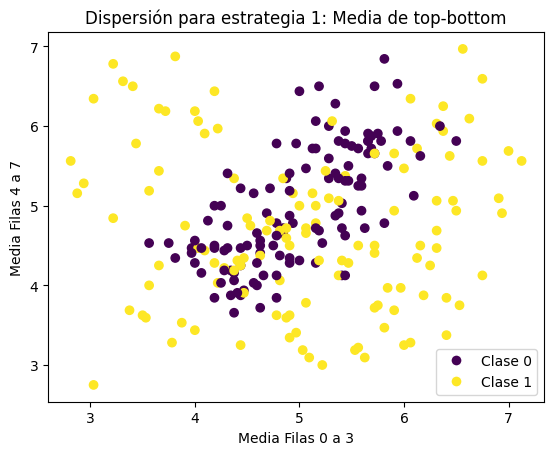

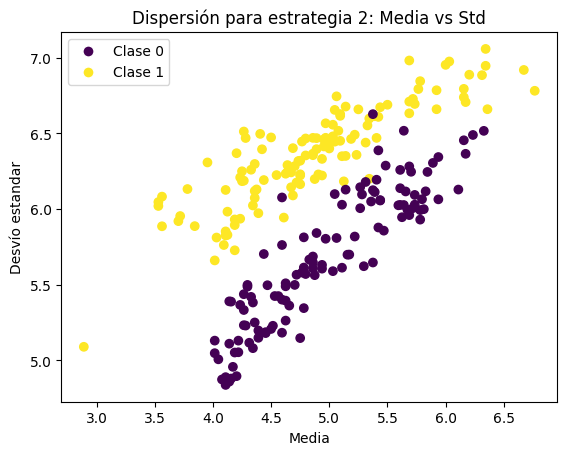

In [16]:
# estrategia mean(top,bottom)
plt.figure()
plt.scatter(x=X_bin_train_features[:,0],
            y=X_bin_train_features[:,1],
            c=y_bin_train,
            cmap='viridis')
plt.title('Dispersión para estrategia 1: Media de top-bottom')
plt.xlabel('Media Filas 0 a 3')
plt.ylabel('Media Filas 4 a 7')

cmap = plt.get_cmap('viridis')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(0.0), markersize=8, label='Clase 0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(1.0), markersize=8, label='Clase 1')]
plt.legend(handles=handles)

plt.savefig('imagenes/P1/features_estrategia1.png')
plt.show()

# estrategia (mean,std)
plt.figure()
plt.scatter(x=X_bin_train_features_2[:,0],
            y=X_bin_train_features_2[:,1],
            c=y_bin_train,
            cmap='viridis')
plt.title('Dispersión para estrategia 2: Media vs Std')
plt.xlabel('Media')
plt.ylabel('Desvío estandar')

cmap = plt.get_cmap('viridis')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(0.0), markersize=8, label='Clase 0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(1.0), markersize=8, label='Clase 1')]
plt.legend(handles=handles)

plt.savefig('imagenes/P1/features_estrategia2.png')


# Complicando las cosas


Ahora volvemos al caso de 10 dígitos y probamos la misma estrategia que estábamos usando anteriormente.

In [17]:
# Definimos un pereceptrón
clasificador10 = Perceptron(eta0=1, random_state=1)

X_train_features = preprocess_features_mean_std(X_train)
X_test_features = preprocess_features_mean_std(X_test)

clasificador10.fit(X_train_features, y_train)

# Imprimir la accuracy en los datos de test.
print("Accuracy en test: " + str(clasificador10.score(X_test_features, y_test)))

# Imprimir las predicciones realizadas para los datos de test

print("Predicciones: " + str(clasificador10.predict(X_test_features)))

Accuracy en test: 0.21212121212121213
Predicciones: [4 2 4 4 4 1 4 4 4 4 1 4 2 0 4 4 2 2 0 0 4 2 0 4 1 4 4 1 4 2 4 0 1 1 4 2 4
 4 1 4 4 1 1 4 1 2 4 0 4 4 2 2 4 2 4 0 4 0 4 1 0 2 2 4 4 0 0 2 2 4 2 4 2 4
 4 4 4 1 4 0 0 4 4 4 0 0 4 2 4 2 1 4 2 4 0 4 4 2 4 2 1 2 4 4 1 2 1 4 4 8 4
 4 4 4 1 4 4 4 0 2 2 4 4 4 0 1 4 4 4 0 0 1 4 4 0 4 4 4 4 2 0 4 1 4 2 4 4 4
 0 2 4 4 2 0 4 2 2 4 4 4 4 4 0 2 4 4 2 2 4 2 0 2 2 4 1 4 4 4 2 4 2 0 2 2 4
 4 4 2 2 0 0 4 1 4 2 2 2 0 4 8 4 2 2 4 2 0 2 2 1 2 0 4 0 4 1 2 4 8 4 4 2 2
 1 2 4 4 4 2 4 1 4 2 1 1 4 1 1 4 4 4 1 0 4 1 2 4 2 2 2 2 4 4 4 2 2 4 4 2 4
 2 1 0 0 1 4 4 1 0 4 0 8 4 4 4 0 4 1 0 4 4 4 4 4 4 2 0 4 0 2 4 4 4 4 4 0 4
 0 4 4 0 2 4 2 4 4 2 0 0 2 2 4 4 1 2 1 2 4 4 1 4 4 8 2 0 4 2 4 4 2 2 4 1 8
 1 0 4 4 0 0 4 4 4 1 2 4 0 4 0 2 4 4 2 1 0 4 4 1 0 2 2 4 0 2 4 0 8 2 0 0 4
 4 2 1 4 4 2 4 1 0 2 4 4 4 2 2 0 4 2 4 0 4 2 0 1 4 4 1 2 1 2 0 4 4 1 4 4 2
 2 4 1 1 4 1 4 2 4 4 0 1 2 4 2 0 4 2 2 1 2 4 4 2 4 4 4 2 2 2 0 0 0 1 4 2 2
 4 4 4 2 4 2 0 4 0 0 4 4 4 0 4 2 4 0 0 4 2 4 4 4

Para intentar entender por qué disminuye tan drásticamente la performance, visualicen las features de las 10 clases coloreando cada punto en un color diferente como hicimos anteriormente.

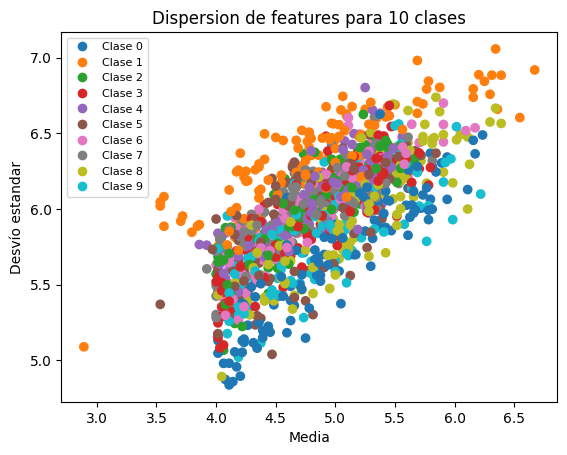

In [18]:
plt.figure()
plt.scatter(x=X_train_features[:,0],
            y=X_train_features[:,1],
            c=y_train,
            cmap='tab10')
plt.title('Dispersion de features para 10 clases')
plt.xlabel('Media')
plt.ylabel('Desvío estandar')
cmap = plt.get_cmap('tab10')

clases = [cmap(i/10) for i in range(0, 10)]

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor= clases[i], markersize=8, label=f'Clase {i}') for i in range(len(clases))]
plt.legend(handles=handles,prop={'size': 8}, loc='upper left')

plt.savefig('imagenes/P1/features_10clases.png')


# Entregable:

Deberán entregar el Colab completo con el código funcionando. Además, deberán incluir (en el mismo Colab) un pequeño informe donde muestren las visualizaciones de las features, y responder a las siguientes preguntas:

1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos?

3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?



# Respuestas:

1. La extracción de características que reportó mejor puntuación es la <b>Estrategia 2</b>. Esta estrategia considera en primera instancia el valor medio de toda la imágen, y por otra parte el desvío estandar de la misma. 
<div style="text-align: center;">
<img src="imagenes/P1/features_estrategia2.png" width="500" />   <img src="imagenes/P1/features_10clases.png" width="500" />
</div>

Como se puede observar, la estrategia 2 logra separar linealmente en situacion de clasifacion binaria. No se obtiene el mismo resultado en multiclase, dado que muchos numeros comparten similitudes en su forma.

2. Para un clasificador que predice aleatoriamente las clases en un problema binario la acurracy esperada es del **50 %** para cada clase. En el caso de un clasificador multiclase de 10 digitos, la acurracy seria de **10 %**, debido a que los datos estan balanceados.

3. Utilizando la mejor estrategia de extracción de características, el clasificador binario obtuvo un **accuracy** en test de: 72 %. Lo que supera a las predicciones aleatorias. En cambio el clasificador multiclase obtuvo un **accuracy** en test: 21 %, mucho menor que una predicción aleatoria

